# NLP Exploration Exercises

In [45]:
#Imports
import re

import unicodedata
import nltk
from wordcloud import WordCloud

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import prepare
import acquire
import env

## 1. Spam Data

* a. Load the spam data set.

In [2]:
#Get SQL database url
url = env.get_db_url('spam_db')

In [3]:
#Define SQL query
query = '''
        SELECT *
        FROM spam
        '''

In [4]:
#Read SQL
df = pd.read_sql(query, url, index_col='id')
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
#Value counts of labels
df['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [6]:
df.iloc[1].text

'Ok lar... Joking wif u oni...'

In [7]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', '4', 'ltgt']

def clean(text):
    '''
    A simple function to cleanup text data.
    
    Args:
        text (str): The text to be cleaned.
        
    Returns:
        list: A list of lemmatized words after cleaning.
    '''
    
    # basic_clean() function from last lesson:
    # Normalize text by removing diacritics, encoding to ASCII, decoding to UTF-8, and converting to lowercase
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    
    # Remove punctuation, split text into words
    words = re.sub(r'[^\w\s]', '', text).split()
    
    
    # lemmatize() function from last lesson:
    # Initialize WordNet lemmatizer
    wnl = nltk.stem.WordNetLemmatizer()
    
    # Combine standard English stopwords with additional stopwords
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    
    # Lemmatize words and remove stopwords
    cleaned_words = [wnl.lemmatize(word) for word in words if word not in stopwords]
    
    return cleaned_words

In [8]:
# we can do that process with a join on a Series and not just a list
# we will do that for ham words, spam words, and all words
# we will pass our basic cleaning on top of that

ham_words = clean(' '.join(df[df.label=="ham"]['text']))
spam_words = clean(' '.join(df[df.label=="spam"]['text']))
all_words = clean(' '.join(df['text']))

In [9]:
len(all_words), len(spam_words), len(ham_words)

(50018, 12044, 37974)

In [10]:
# let's get some sights on word frequency by taking our words back apart
# we will split each set of words by the spaces,
# turn that into a list, cast that list as a Series,
# and then take the value counts of that Series
# We will do this for each type of word present

ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [11]:
spam_freq.head()

call    359
free    216
txt     150
ur      144
text    137
dtype: int64

In [12]:
ham_freq.head()

im      449
get     314
go      273
ok      272
dont    257
dtype: int64

* b. Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?

They represent the data in different ways, but tell the same story

### Ham Words

In [13]:
top_20_ham_bigrams = (pd.Series(nltk.ngrams(ham_words, 2))
                      .value_counts()
                      .head(20))

top_20_ham_bigrams


(call, later)      52
(ill, call)        48
(let, know)        42
(sorry, ill)       39
(dont, know)       32
(good, morning)    31
(new, year)        30
(take, care)       26
(im, going)        24
(ok, lor)          22
(pls, send)        22
(im, gonna)        20
(happy, new)       19
(good, night)      19
(wat, time)        18
(last, night)      18
(hi, hi)           18
(great, day)       17
(nice, day)        15
(dont, want)       15
dtype: int64

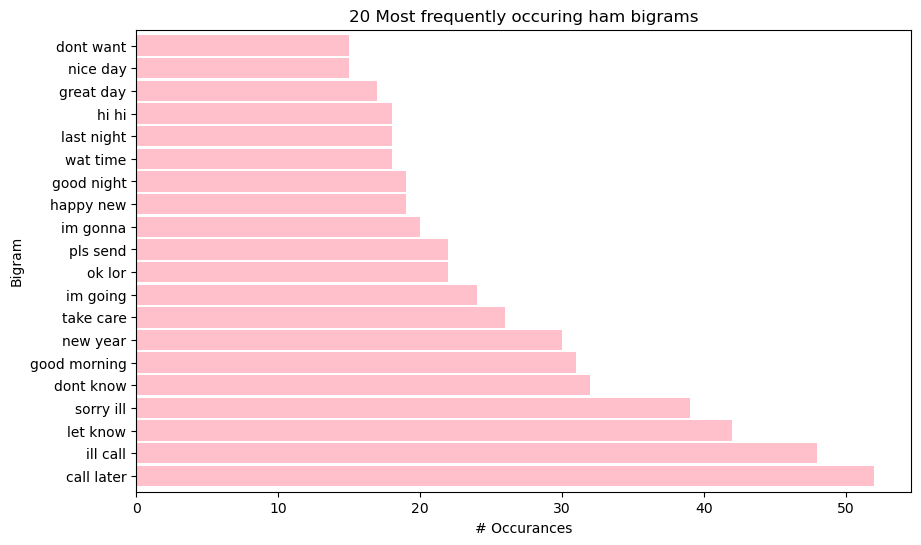

In [14]:
top_20_ham_bigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ham bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ham_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

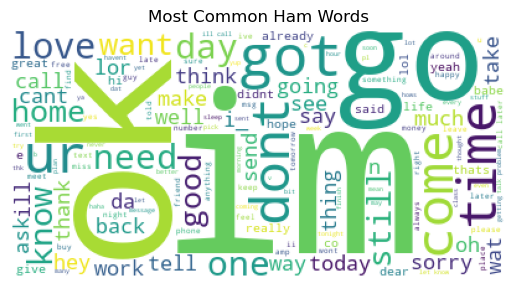

In [15]:
img = WordCloud(background_color='white').generate(' '.join(ham_words))

plt.imshow(img)
plt.axis('off')
plt.title('Most Common Ham Words')
plt.show()

In [16]:
top_20_spam_bigrams = (pd.Series(nltk.ngrams(spam_words, 2))
                      .value_counts()
                      .head(20))
top_20_spam_bigrams

(please, call)          44
(customer, service)     27
(po, box)               24
(a1000, cash)           23
(guaranteed, call)      23
(prize, guaranteed)     22
(every, week)           19
(await, collection)     19
(chance, win)           19
(selected, receive)     19
(send, stop)            19
(land, line)            18
(urgent, mobile)        18
(claim, call)           17
(valid, 12hrs)          17
(call, 08000930705)     16
(account, statement)    16
(prize, claim)          16
(sae, tc)               16
(ur, mob)               15
dtype: int64

### Spam words

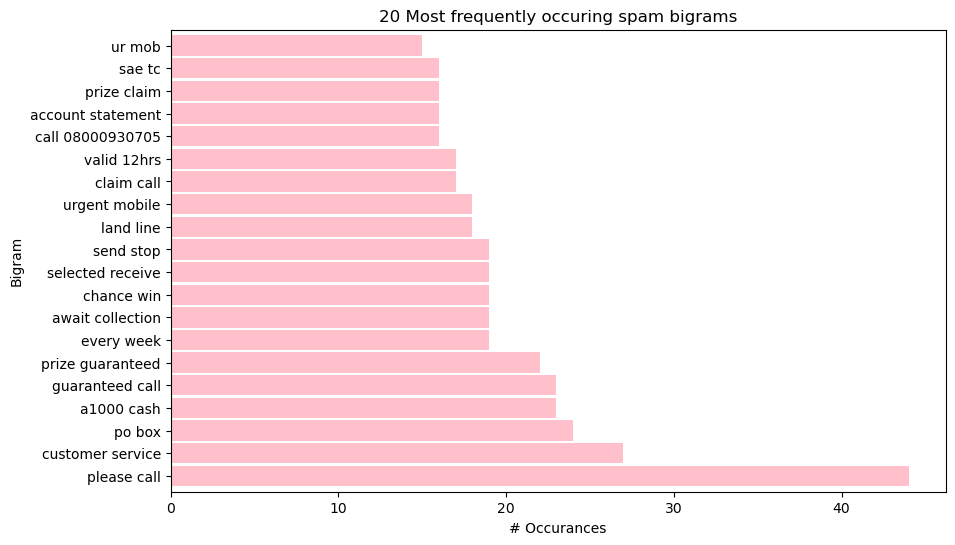

In [17]:
top_20_spam_bigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring spam bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_spam_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

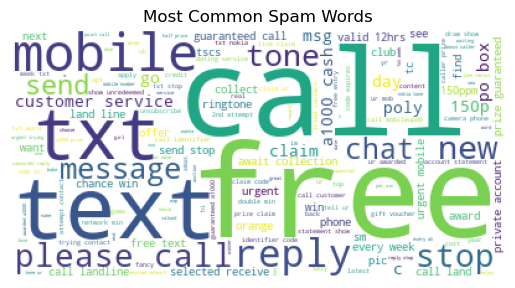

In [18]:
img = WordCloud(background_color='white').generate(' '.join(spam_words))

plt.imshow(img)
plt.axis('off')
plt.title('Most Common Spam Words')
plt.show()

* c. Is there any overlap in the bigrams for the spam data and the ham data? no

* d. Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

In [19]:
top_20_ham_trigrams = (pd.Series(nltk.ngrams(ham_words, 3))
                      .value_counts()
                      .head(20))

top_20_ham_trigrams

(ill, call, later)           42
(sorry, ill, call)           38
(happy, new, year)           19
(pls, send, message)         13
(pick, phone, right)         12
(right, pls, send)           12
(phone, right, pls)          12
(cant, pick, phone)          12
(hi, hi, hi)                 11
(x, x, x)                     8
(good, morning, dear)         7
(kiss, across, sea)           6
(convey, birthday, wish)      6
(pls, convey, birthday)       6
(call, later, meeting)        6
(cabin, pa, said)             5
(set, callertune, caller)     5
(5, minuts, latr)             5
(entered, cabin, pa)          5
(story, man, last)            5
dtype: int64

In [20]:
top_20_spam_trigrams = (pd.Series(nltk.ngrams(spam_words, 3))
                      .value_counts()
                      .head(20))

top_20_spam_trigrams

(prize, guaranteed, call)              21
(call, customer, service)              15
(reply, call, 08000930705)             14
(land, line, claim)                    14
(private, 2003, account)               13
(2003, account, statement)             13
(guaranteed, a1000, cash)              12
(show, 800, unredeemed)                12
(camcorder, reply, call)               12
(every, week, txt)                     11
(bonus, caller, prize)                 11
(urgent, trying, contact)              11
(anytime, network, min)                11
(please, call, customer)               11
(customer, service, representative)    10
(cash, await, collection)              10
(speak, live, operator)                10
(a2000, bonus, caller)                 10
(mob, every, week)                      9
(ur, mob, every)                        9
dtype: int64

# 2. Explore the blog articles using the techniques discussed in the exploration lesson.

In [21]:
urls = ['https://codeup.com/featured/apida-heritage-month/','https://codeup.com/featured/women-in-tech-panelist-spotlight/','https://codeup.com/featured/women-in-tech-rachel-robbins-mayhill/','https://codeup.com/codeup-news/women-in-tech-panelist-spotlight-sarah-mellor/','https://codeup.com/events/women-in-tech-madeleine/']

In [22]:
df = prepare.wrangle_codeup(urls)

In [23]:
blogs = ' '.join(df['lemmatized'])

In [24]:
blog_words = clean(' '.join(df['lemmatized']))

In [25]:
top_20_lem_bigrams = (pd.Series(nltk.ngrams(blog_words, 2))
                      .value_counts()
                      .head(20))

In [26]:
top_20_lem_bigrams

(data, science)               12
(woman, tech)                 12
(march, 29th)                  8
(san, antonio)                 5
(bit, respective)              4
(panelist, spotlight)          4
(history, month)               4
(woman, history)               4
(honor, woman)                 4
(panel, honor)                 4
(tech, panel)                  4
(hosting, woman)               4
(codeup, hosting)              4
(dont, forget)                 4
(forget, tune)                 4
(tune, march)                  4
(29th, sit)                    4
(sit, insightful)              4
(insightful, conversation)     4
(apida, individual)            4
dtype: int64

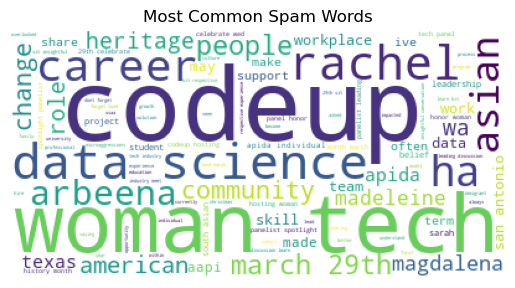

In [27]:
img = WordCloud(background_color='white').generate(' '.join(blog_words))

plt.imshow(img)
plt.axis('off')
plt.title('Most Common Spam Words')
plt.show()

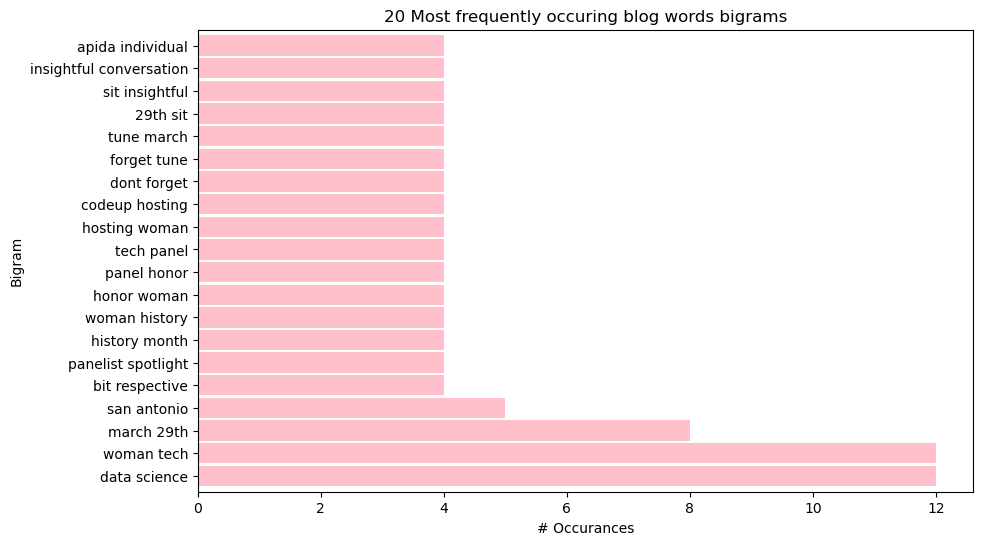

In [28]:
top_20_lem_bigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring blog words bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_lem_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

In [29]:
top_20_lem_trigrams = (pd.Series(nltk.ngrams(blog_words, 3))
                      .value_counts()
                      .head(20))
top_20_lem_trigrams

(like, spotlight, panelist)        4
(honor, woman, history)            4
(tech, industry, meet)             4
(woman, tech, industry)            4
(experience, woman, tech)          4
(respective, experience, woman)    4
(bit, respective, experience)      4
(learn, bit, respective)           4
(discussion, learn, bit)           4
(leading, discussion, learn)       4
(panelist, leading, discussion)    4
(spotlight, panelist, leading)     4
(history, month, march)            4
(wed, like, spotlight)             4
(celebrate, wed, like)             4
(2023, celebrate, wed)             4
(29th, 2023, celebrate)            4
(woman, history, month)            4
(panel, honor, woman)              4
(month, march, 29th)               4
dtype: int64

## 3. Explore the news articles using the techniques discussed in the exploration lesson. Use the category variable when exploring.

In [31]:
news = prepare.wrangle_news()

In [33]:
articles = ' '.join(news['lemmatized'])

In [34]:
article_words = clean(' '.join(news['lemmatized']))

In [35]:
top_20_article_bigrams = (pd.Series(nltk.ngrams(article_words, 2))
                      .value_counts()
                      .head(20))

In [37]:
top_20_article_bigrams

(west, indie)           15
(world, cup)             9
(shah, rukh)             8
(micron, technology)     6
(social, medium)         6
(odi, world)             6
(rukh, khan)             5
(narendra, modi)         5
(tech, mahindra)         4
(2023, match)            4
(qualifier, 2023)        4
(cup, qualifier)         4
(pm, narendra)           4
(greater, noida)         4
(passed, away)           4
(actor, rajpal)          3
(200, crore)             3
(india, today)           3
(kerala, story)          3
(crore, india)           3
dtype: int64

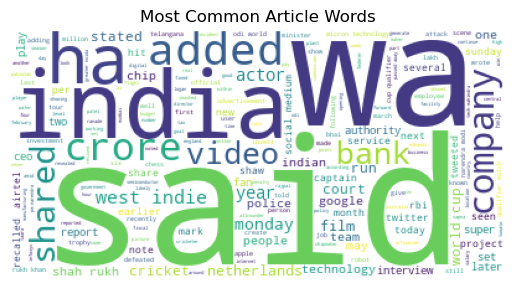

In [38]:
img = WordCloud(background_color='white').generate(' '.join(article_words))

plt.imshow(img)
plt.axis('off')
plt.title('Most Common Article Words')
plt.show()

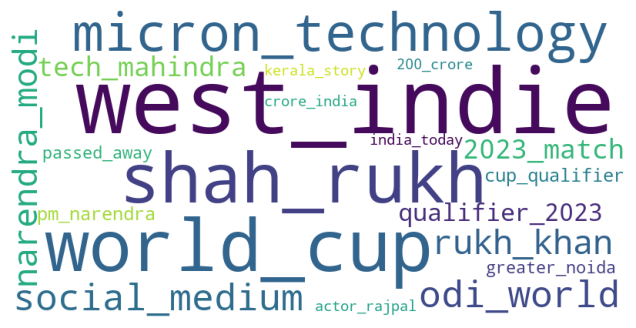

In [44]:
data = {k[0] + '_' + k[1]: v for k, v in top_20_article_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

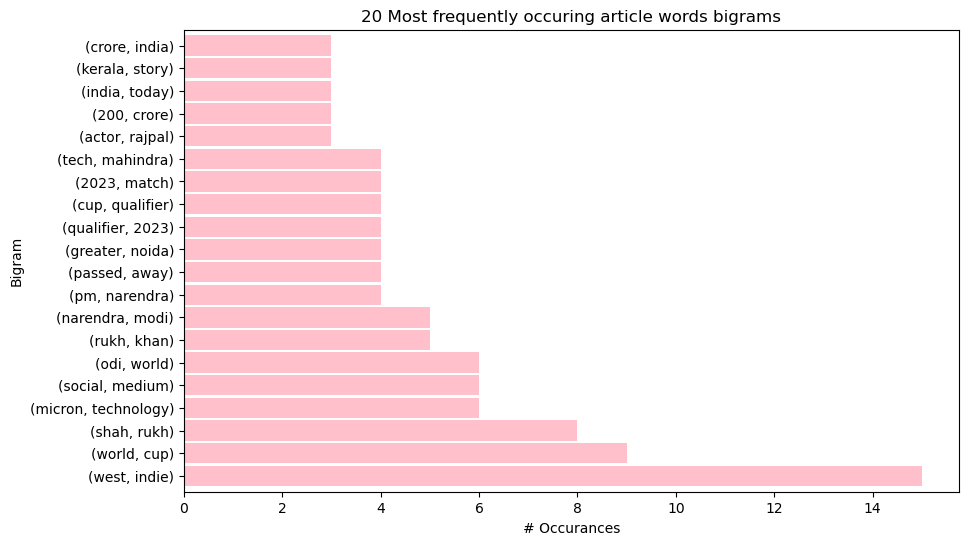

In [39]:
top_20_article_bigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring article words bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_article_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])

In [40]:
top_20_article_trigrams = (pd.Series(nltk.ngrams(article_words, 3))
                      .value_counts()
                      .head(20))

In [41]:
top_20_article_trigrams

(odi, world, cup)                   6
(shah, rukh, khan)                  5
(world, cup, qualifier)             4
(cup, qualifier, 2023)              4
(qualifier, 2023, match)            4
(pm, narendra, modi)                4
(social, medium, platform)          3
(super, odi, world)                 3
(adding, ha, set)                   2
(service, firm, infosys)            2
(infosys, said, ha)                 2
(said, ha, selected)                2
(ha, selected, denmarkbased)        2
(selected, denmarkbased, danske)    2
(denmarkbased, danske, bank)        2
(danske, bank, partner)             2
(west, indie, player)               2
(bank, partner, accelerate)         2
(partner, accelerate, lender)       2
(accelerate, lender, digital)       2
dtype: int64

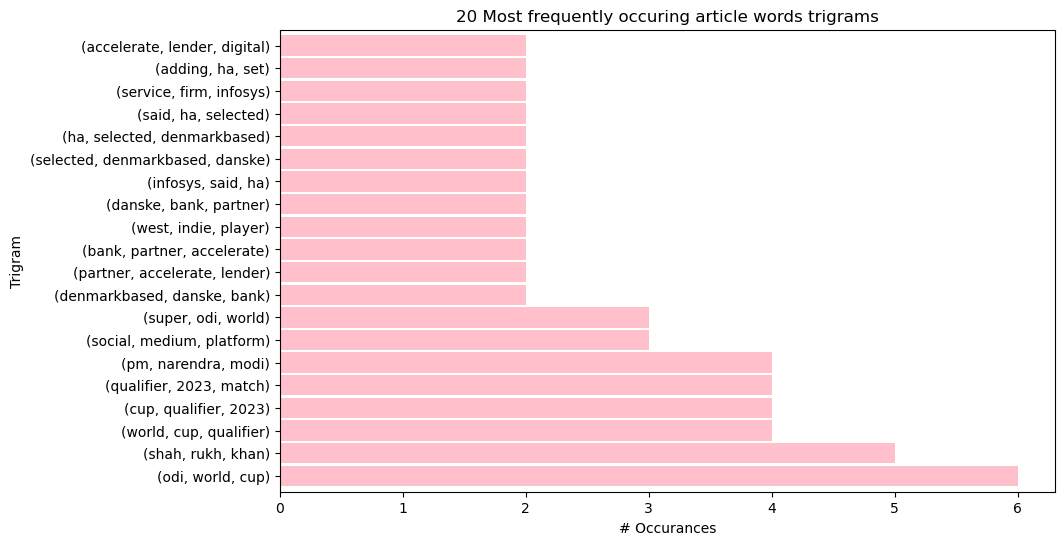

In [42]:
top_20_article_trigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring article words trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_article_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])